In [1]:
import os
import sys
sys.path.append('./code/')

from utils import *
from DataGenerator import DataGenerator

## Reading Data

In [2]:
image_path = 'Flickr30k/images/'
data = pd.read_csv("Flickr30k/captions.txt")
data.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,Two young White males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## Visualization

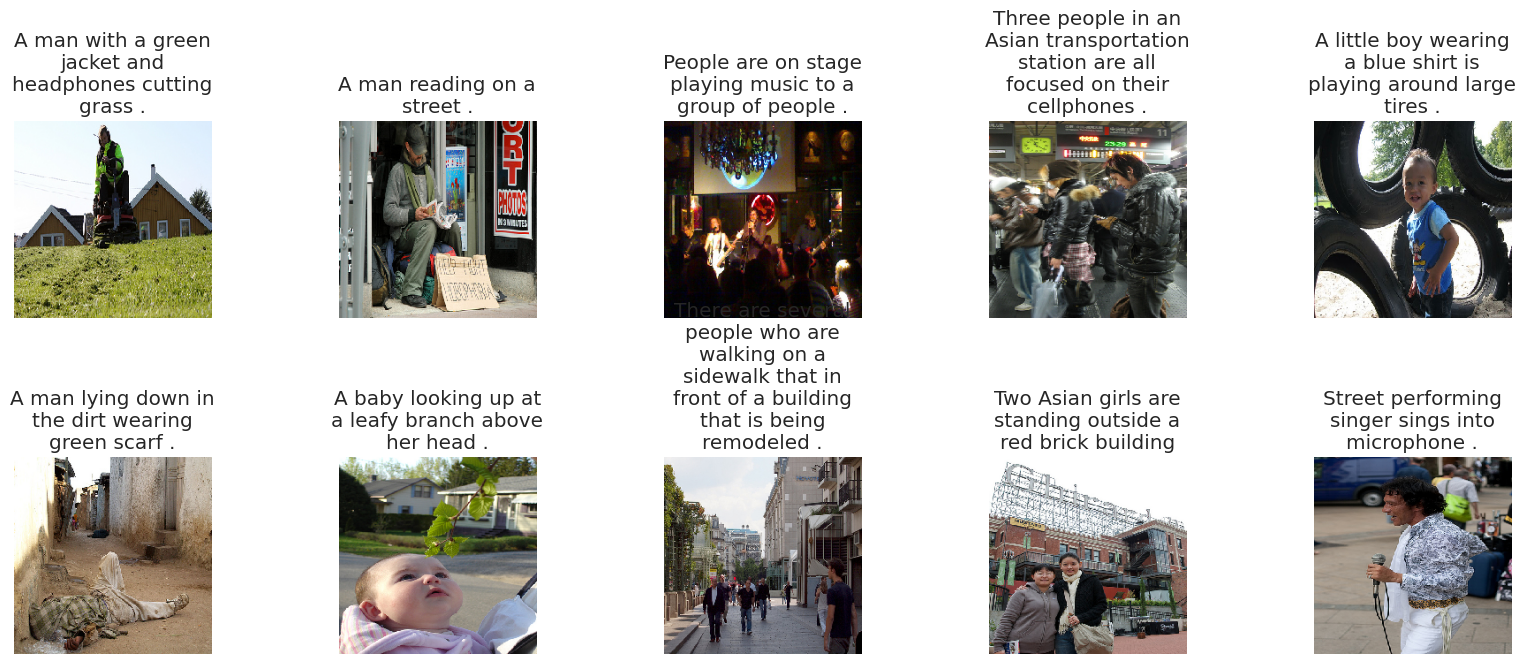

In [3]:
display_images(data.sample(10), path_image = image_path)

## Caption pre-processing

In [4]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:5]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

## Tokenization and Encoded Representation

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

## Train-test split

In [6]:
images = data['image'].unique().tolist()
split_index_val = round(0.80 * len(images))

train_images = images[ : split_index_val]
val_images = images[split_index_val : split_index_val + int(0.15 * split_index_val)]
test_images = images[split_index_val + int(0.15 * split_index_val) : ]

train = data[data['image'].isin(train_images)]
train.reset_index(inplace = True, drop = True)

test = data[data['image'].isin(val_images)]
test.reset_index(inplace = True, drop = True)

holdout = data[data['image'].isin(test_images)]
holdout.reset_index(inplace = True, drop = True)

## Image Feature Extraction

In [7]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
model = NASNetLarge() 
m = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 331
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = m.predict(img, verbose=0)
    features[image] = feature

  0%|          | 0/31764 [00:00<?, ?it/s]

## Modelling

In [9]:
input1 = Input(shape=(4032,))

img_features = Dense(2048, activation='relu')(input1)
img_features1 = Dense(1024, activation='relu')(img_features)
img_features1 = Dense(512, activation='relu')(img_features1)
img_features_reshaped = Reshape((1, 512), input_shape = (512,))(img_features1)

input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped, sentence_features],axis=1)

sentence_features = LSTM(512)(merged)
x = Dropout(0.2)(sentence_features)
x = add([x, img_features1])

x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [10]:
from tensorflow.keras.utils import plot_model

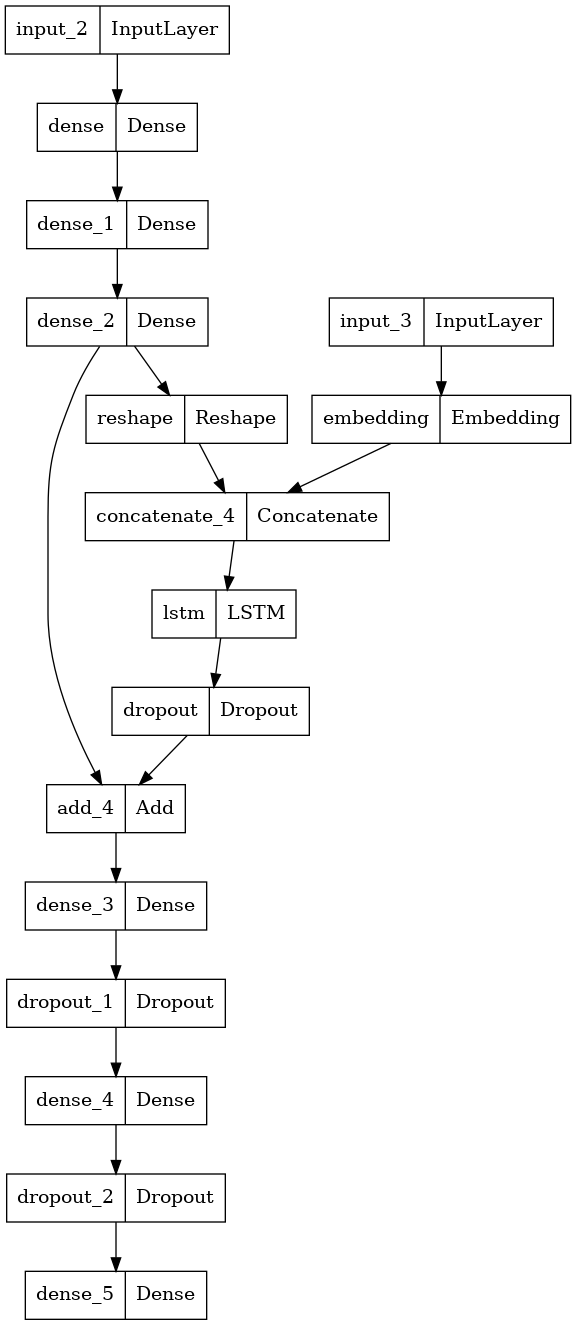

In [11]:
plot_model(caption_model)

## Model Modification
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

In [12]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4032)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         8259584     ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         2098176     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 512)          524800      ['dense_1[0][0]']                
                                                                                            

In [13]:
train_generator = DataGenerator(df=train,X_col='image',y_col='caption',batch_size=32,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = DataGenerator(df=test,X_col='image',y_col='caption',batch_size=32,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [14]:
model_name = "Model_NASnet50_RUN2.h5"

checkpoint = ModelCheckpoint(model_name, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 6, verbose = 1, restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose = 1, factor = 0.2, min_lr = 0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs = 100,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/100
3970/3970 [==============================] - ETA: 0s - loss: 4.3995
Epoch 1: val_loss improved from inf to 4.10596, saving model to Model_NASnet50_RUN2.h5
3970/3970 [==============================] - 1056s 265ms/step - loss: 4.3995 - val_loss: 4.1060 - lr: 0.0010
Epoch 2/100
3970/3970 [==============================] - ETA: 0s - loss: 3.6233
Epoch 2: val_loss improved from 4.10596 to 3.84308, saving model to Model_NASnet50_RUN2.h5
3970/3970 [==============================] - 247s 62ms/step - loss: 3.6233 - val_loss: 3.8431 - lr: 0.0010
Epoch 3/100
3970/3970 [==============================] - ETA: 0s - loss: 3.3754
Epoch 3: val_loss improved from 3.84308 to 3.79281, saving model to Model_NASnet50_RUN2.h5
3970/3970 [==============================] - 244s 61ms/step - loss: 3.3754 - val_loss: 3.7928 - lr: 0.0010
Epoch 4/100
3970/3970 [==============================] - ETA: 0s - loss: 3.2252
Epoch 4: val_loss did not improve from 3.79281
3970/3970 [==============================

## Inference
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## Learning Curve
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

3.50222
3.44626
3.37660

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Caption Generation Utility Functions
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [ ]:
get_predictions(15, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features, verbosity = 0)